## View and filter ensemble members

In [1]:
import os
import pandas as pd
import glob
from matplotlib import pyplot as plt
import re

## Functions

In [2]:
def extract_case_number(filename):
    # Regular expression pattern to find two digits between "_" and ".csv"
    pattern = r'_(\d{2})\.csv'
    
    # Search for the pattern in the filename
    match = re.search(pattern, filename)
    
    # If a match is found, return the first group (the two digits)
    if match:
        return match.group(1)  # Returns the two digits as a string
    else:
        return None  # Returns None if no match is found

def make_histograms_of_metrics(df):

    metrics = df.columns[1:]
    
    for metric in metrics:
        plt.hist(df[metric], bins=25, alpha=0.9, color='white', edgecolor='black', label = "Model")
        if metric in vln.keys():
            plt.xlabel(vln[metric])
        else:
            plt.xlabel(metric)
        plt.ylabel("Number of ensemble members")
        plt.legend()
        plt.tight_layout()
        plt.show()

## Set paths

In [3]:
path_to_metrics = '/glade/work/adamhb/processed_output/CZ2_equilibrium_041924_XX_-17e2acb6a_FATES-1449c787'
files = glob.glob(os.path.join(path_to_metrics,'*'))

## Load data

In [4]:
df = pd.DataFrame()
for file in files:
    tmp = pd.read_csv(file, dtype={'inst_tag':str})
    to_drop = tmp.columns[0]
    tmp.drop(to_drop,axis=1,inplace=True)
    case_number = extract_case_number(file)
    tmp['case_number'] = case_number
    df = pd.concat([df,tmp],axis = 0)

print(len(df), "ensemble members analyzed.")

896 ensemble members analyzed.


## Variable long names

In [5]:
vln = {'Burned_area':'Burned area [% yr-1]',
       'Pct_high_severity_3500':'High severity fire [% of fires > 3500 kW m-1]',
       'Pct_high_severity_1700':'High severity fire [% of fires > 1700 kW m-1]',
       'AGCD':'Above-ground carbon density [Kg C m-2]',
       'BA_conifer':'Conifer basal area (dbh > 10 cm) [m-2 ha-1]',
       'Pct_shrub_cover_canopy':'Shrub cover [%]',
       'VCD':'Vegetation carbon density [Kg C m-2]',
       'Pct_conifer_cover_canopy':'Conifer cover [%]',
       'Pct_oak_cover_canopy':'Oak cover [%]',
       'Pct_pine_cover_canopy':'Pine cover [%]',
       'Pct_cedar_cover_canopy':'Cedar cover [%]',
       'Pct_fir_cover_canopy':'Fir cover [%]',
       'BA_pine':'Pine basal area (dbh > 10 cm) [m-2 ha-1]',
       'BA_cedar':'Cedar basal area (dbh > 10 cm) [m-2 ha-1]',
       'BA_fir':'Fir basal area (dbh > 10 cm) [m-2 ha-1]',
       'BA_oak':'Oak  basal area (dbh > 10 cm) [m-2 ha-1]',
       'TreeStemD':'Tree Stem Density [N ha-1] (> 10 cm dbh)',
       'Combustible_fuel':'Combustible fuel [Kg C m-2]',
       'NPP':'NPP',
       'mort_pine_fire_per_cap':'Pine fire mort [per capita (%) yr-1]',
       'mort_pine_cstarve_per_cap':'Pine cstarve mort [per capita (%) yr-1]',
       'mort_pine_hydr_per_cap':'Pine hydr failure mort [per capita (%) yr-1]',
       'mort_cedar_fire_per_cap':'Cedar fire mort [per capita (%) yr-1]',
       'mort_cedar_cstarve_per_cap':'Cedar cstarve mort [per capita (%) yr-1]',
       'mort_cedar_hydr_per_cap':'Cedar hydr failure mort [per capita (%) yr-1]',
       'mort_fir_fire_per_cap':'Fir fire mort [per capita (%) yr-1]',
       'mort_fir_cstarve_per_cap':'Fir cstarve mort [per capita (%) yr-1]',
       'mort_fir_hydr_per_cap':'Fir hydr failure mort [per capita (%) yr-1]',
       'mort_shrub_fire_per_cap':'Shrub fire mort [per capita (%) yr-1]',
       'mort_shrub_cstarve_per_cap':'Shrub cstarve mort [per capita (%) yr-1]',
       'mort_shrub_hydr_per_cap':'Shrub hydr failure mort [per capita (%) yr-1]',
       'mort_oak_fire_per_cap':'Oak fire mort [per capita (%) yr-1]',
       'mort_oak_cstarve_per_cap':'Oak cstarve mort [per capita (%) yr-1]',
       'mort_oak_hydr_per_cap':'Oak hydr failure mort [per capita month-1]',
       'SMP':'Soil matric potential [MPa 0.4 m depth]',
       'StemD10_pine':'Pine stem density [N ha-1] (> 10 cm dbh)',
       'mort_pine_fire_n_per_ha':'Pine fire mort [N ha-1 month-1]',
       'Rec_pine':'Recruitment pine [N ha-1 yr -1]',
       'Rec_cedar':'Recruitment cedar [N ha-1 yr -1]',
       'Rec_fir':'Recruitment fir [N ha-1 yr -1]',
       'Rec_shrub':'Recruitment shrub [N ha-1 yr -1]',
       'Rec_oak':'Recruitment oak [N ha-1 yr -1]'
       }

## PEAS ecological criteria used in first iteration

In [6]:
# There should be at least 5 trees ha-1 larger than 40 cm dbh
enough_large_trees = df["TreeStemD_40"] > 5

# There should be at least 5 percent total shrub cover
enough_shrubs = df["Pct_shrub_cover"] > 0.05

# Pine should not be failing
enough_pine = df["BA_pine"] > 0.1

# There should be no more than 2 pfts failing
coexistence_filter = df["FailedPFTs"] < 3

# AGB should be at least 2 Kg of Carbon per m2
enough_agb = df["AGCD"] > 2

# Burned area should be between 1 and 11 percent per year
# This is the range in Williams+ 2023 and Mallek+ and then I added +- 2 perecnt
burned_area = (df['Burned_area'] > 0.01) & (df['Burned_area'] < 0.11) 

# Percent of fires burning at high severity (3500 kw m-1) should be 20%
# Note the actual range is estimated to be 1-6, but using this exact range
# would cull too many parameters

phs = df['Pct_high_severity_3500'] < 20 

# All filters
criteria = enough_large_trees & enough_shrubs & enough_pine &\
              coexistence_filter & enough_agb & burned_area & phs

print(len(df[criteria]),"meet the old criteria")

81 meet the old criteria


## Stricter ecological criteria

In [7]:
obs_PEAS = {'Burned_area':[0.03,0.11], #Range for burned area was calculated from the FRI estimates given in Table 3 of Williams et al., 2023. BurnFrac = 1/ FRI. The ranges given in Safford and Stevens, 2017 are larger.
       'Pct_high_severity_3500':[1,6], # Williams+ 2023; Safford and Stevens, 2017, Stephens+ 2015
       'Pct_high_severity_1700':[1,6],
       'BA_conifer':[10.6,29.5], # 10 cm dbh
       'Pct_shrub_cover_canopy':[0.09,0.54], # DRY and WET
      }

# There should be at least 5 percent total shrub cover
shrub_cover = (df["Pct_shrub_cover"] > obs_PEAS["Pct_shrub_cover_canopy"][0]) & (df["Pct_shrub_cover_canopy"] < obs_PEAS["Pct_shrub_cover_canopy"][1])
burned_area = (df['Burned_area'] > obs_PEAS["Burned_area"][0]) & (df['Burned_area'] < obs_PEAS["Burned_area"][1])
enough_conifer_basal_area = (df['BA_conifer'] > obs_PEAS["BA_conifer"][0] / 2) # I divided this by 2 because it was only 150 years

criteria = shrub_cover & burned_area & enough_conifer_basal_area
df_filtered = df[criteria]
print(len(df_filtered), "meet stricter criteria")

57 meet stricter criteria


In [8]:
df_filtered[['BA_conifer','BA_pine','BA_cedar','BA_fir','BA_oak',
             'Pct_shrub_cover_canopy','Pct_shrub_cover','TreeStemD_40','ShannonE',
            'Burned_area','Pct_high_severity_1700']].sort_values(by = "ShannonE",ascending=False)

,BA_conifer,BA_pine,BA_cedar,BA_fir,BA_oak,Pct_shrub_cover_canopy,Pct_shrub_cover,TreeStemD_40,ShannonE,Burned_area,Pct_high_severity_1700
89,14.462681,1.774367e+00,9.462259,3.226054,1.223322e-01,0.350333,0.919968,24.430125,0.818914,0.067,6.632653
14,9.033898,2.643935e+00,5.107602,1.282360,5.119908e-10,0.185956,0.304137,40.992121,0.779977,0.082,0.641026
102,14.640276,6.782937e+00,7.829776,0.027564,1.505004e-01,0.142975,0.212995,23.665389,0.764854,0.036,1.149425
99,17.564371,8.493074e+00,7.697919,1.373377,0.000000e+00,0.515119,0.644859,31.899752,0.747675,0.037,6.535948
62,6.092636,5.847121e+00,0.088421,0.157094,2.375610e+00,0.145565,0.267124,3.549393,0.746771,0.069,14.634146
124,7.237496,1.653599e+00,3.960426,1.623472,1.389732e-06,0.445316,0.510685,8.481003,0.745957,0.038,0.000000
111,7.597763,4.571197e+00,2.593729,0.432838,3.822160e-04,0.209678,0.229476,14.125967,0.733549,0.079,4.069767
43,6.335800,5.329581e+00,0.471153,0.535065,9.442980e-02,0.265392,0.318042,16.669977,0.698792,0.049,0.990099
8,35.306741,1.867220e+01,15.680420,0.954122,0.000000e+00,0.294699,0.315319,134.117547,0.673402,0.089,1.595745
123,23.673926,2.448138e+00,19.230629,1.995164,0.000000e+00,0.510368,0.563794,40.748655,0.659519,0.060,0.000000


## View distribution of metrics

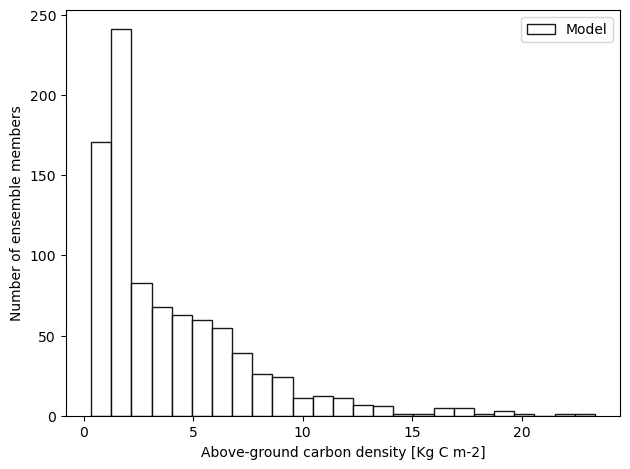

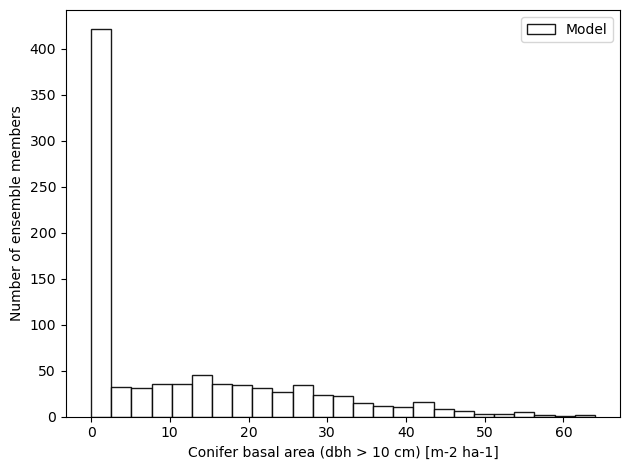

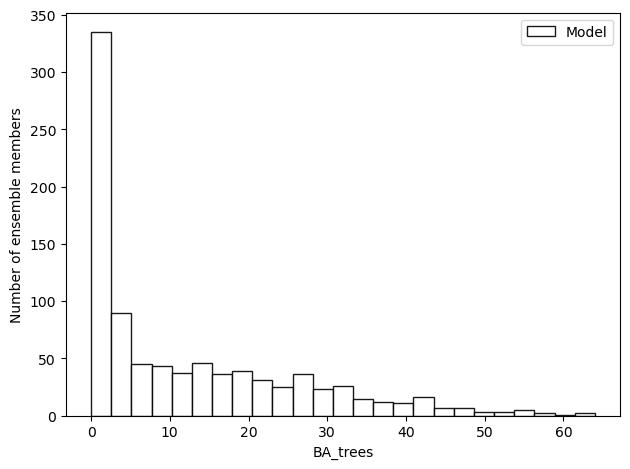

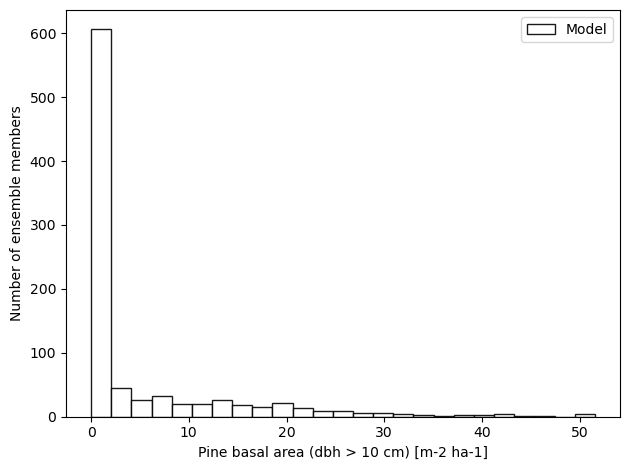

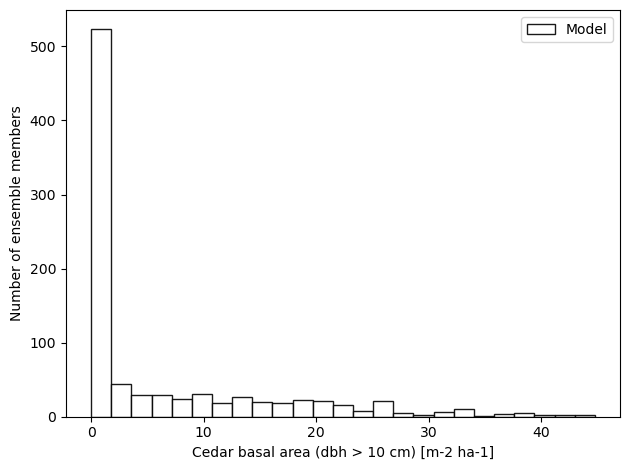

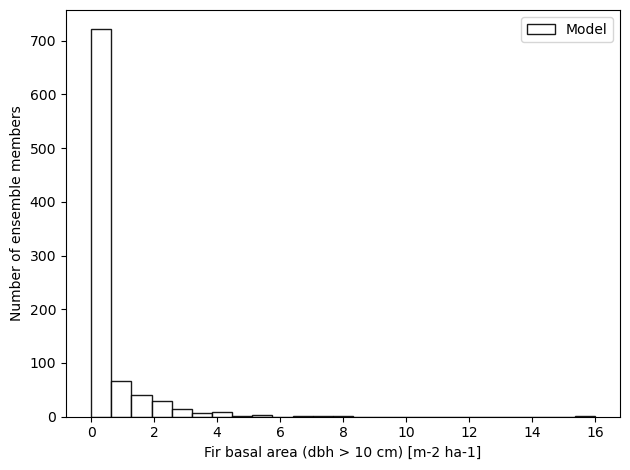

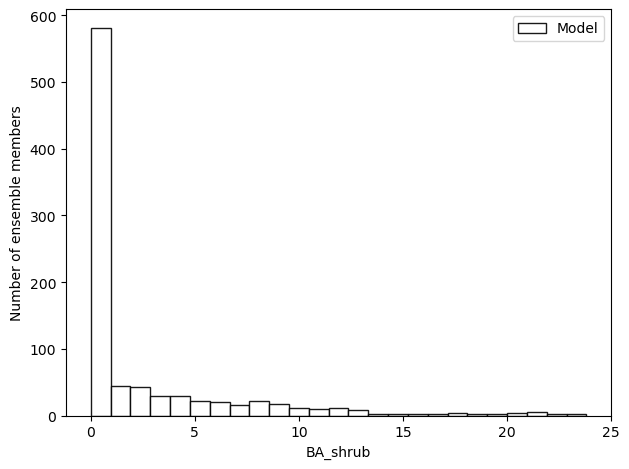

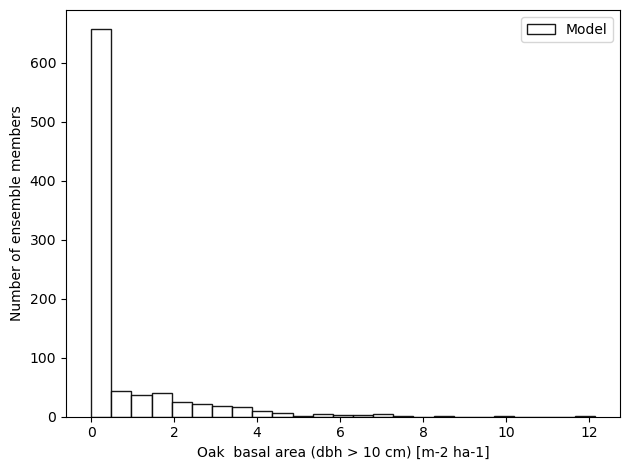

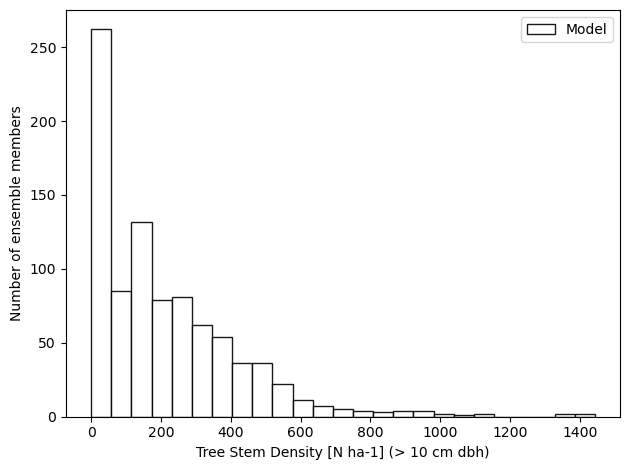

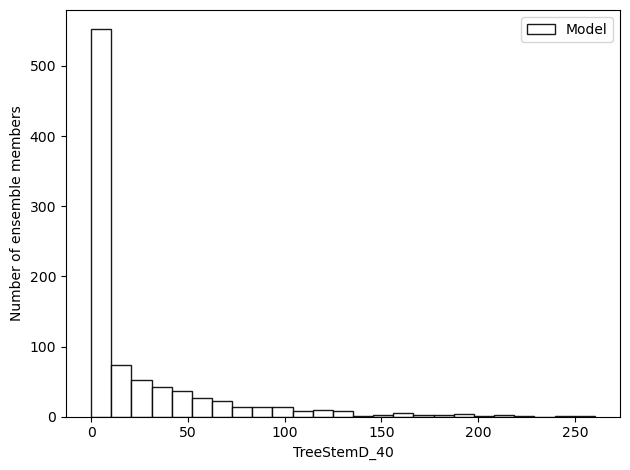

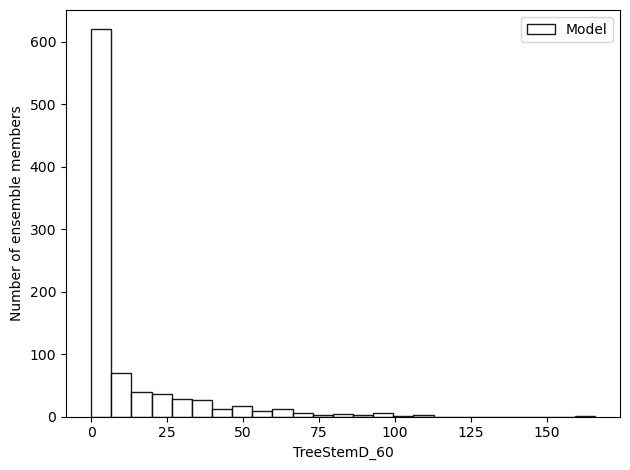

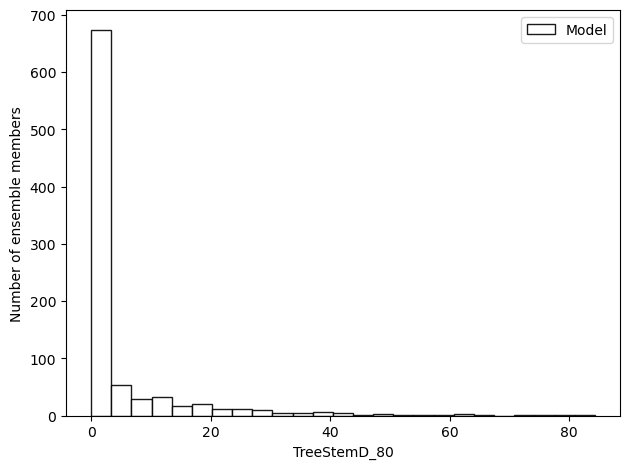

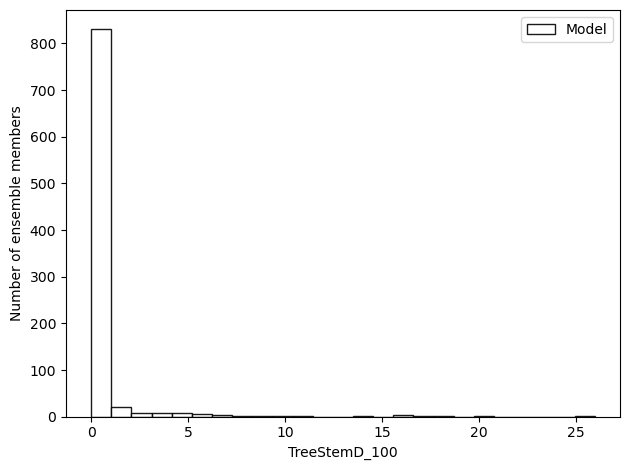

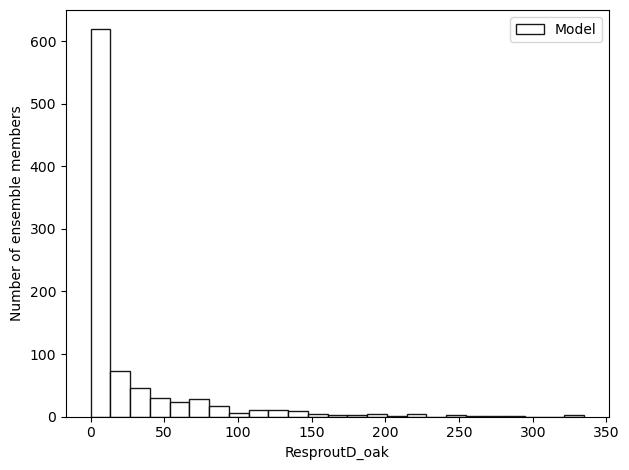

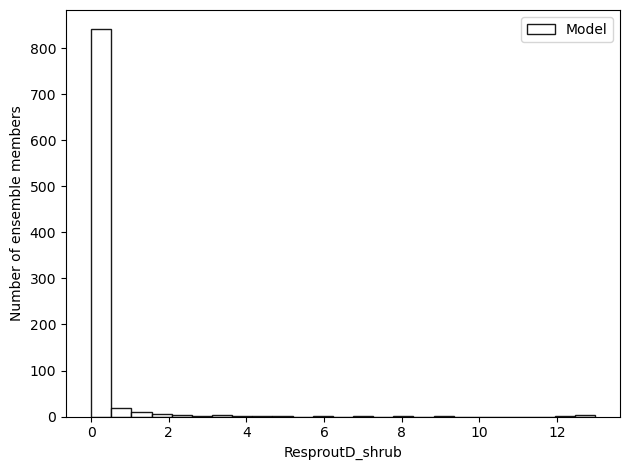

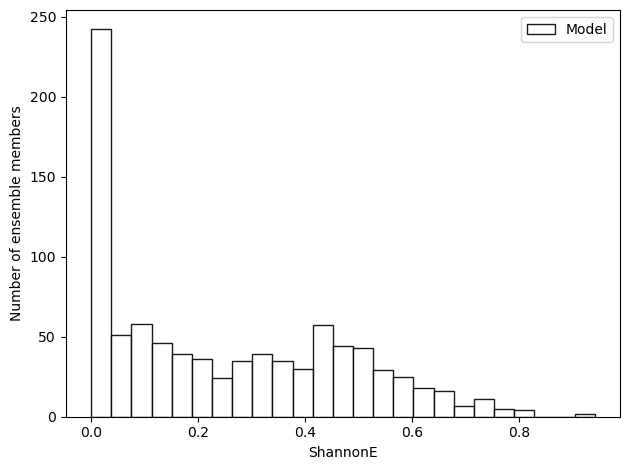

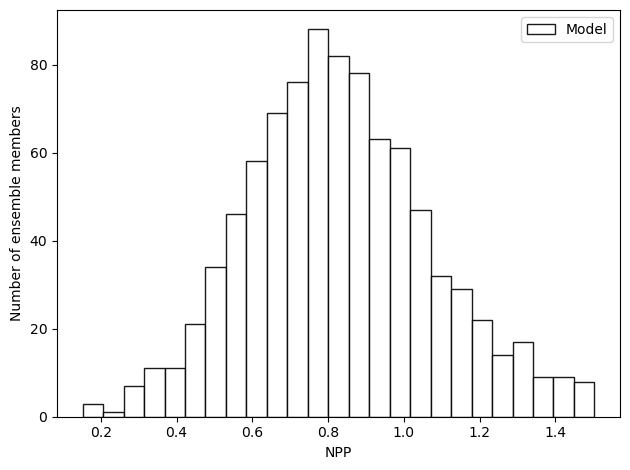

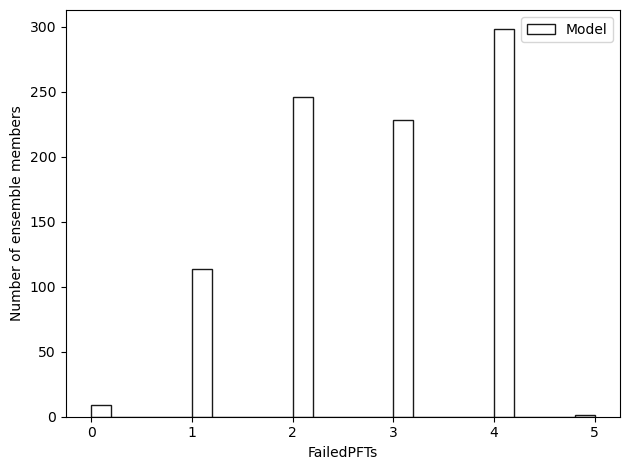

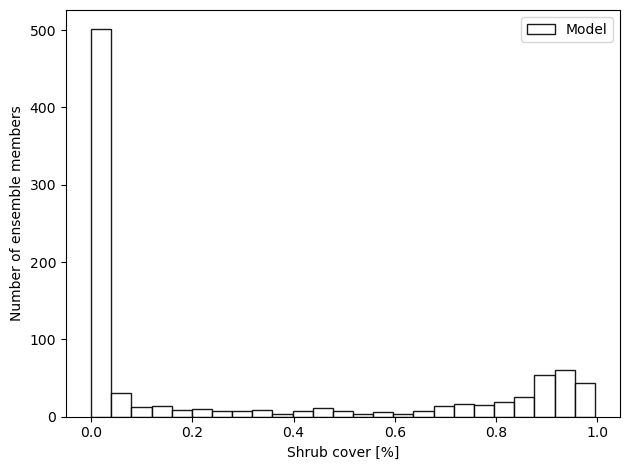

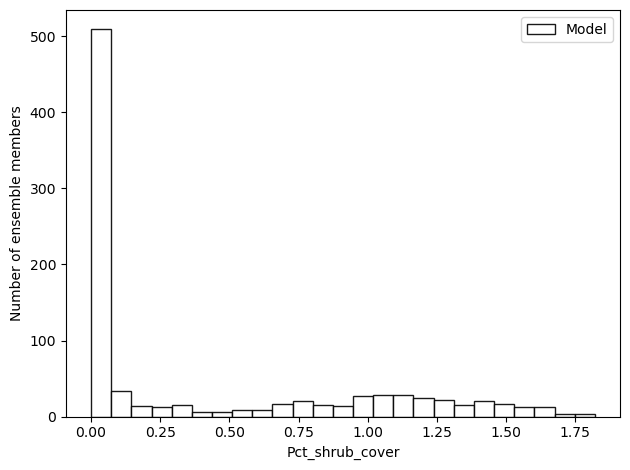

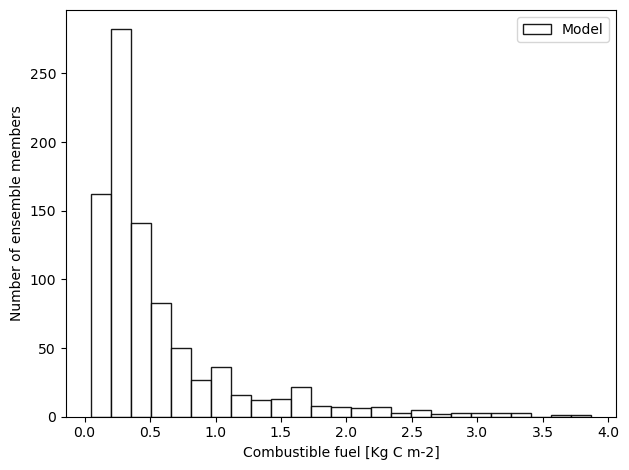

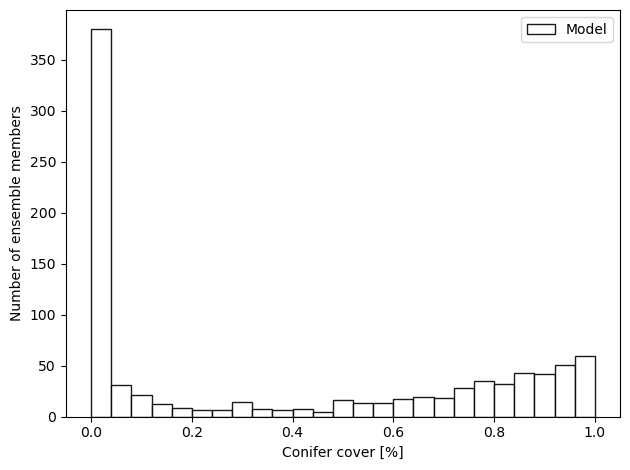

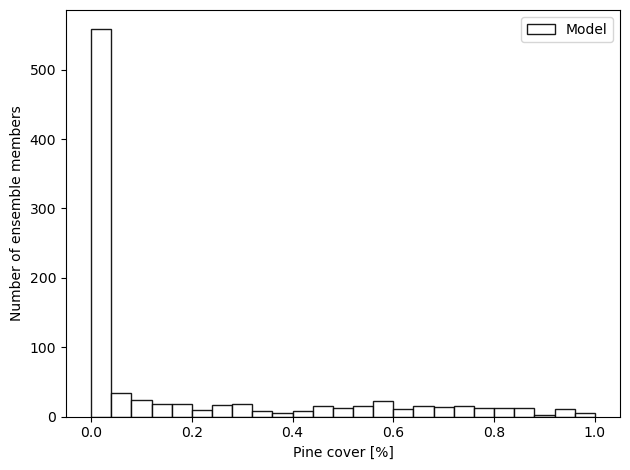

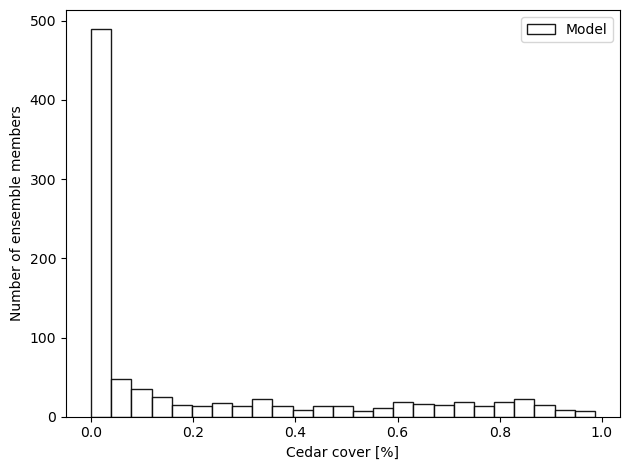

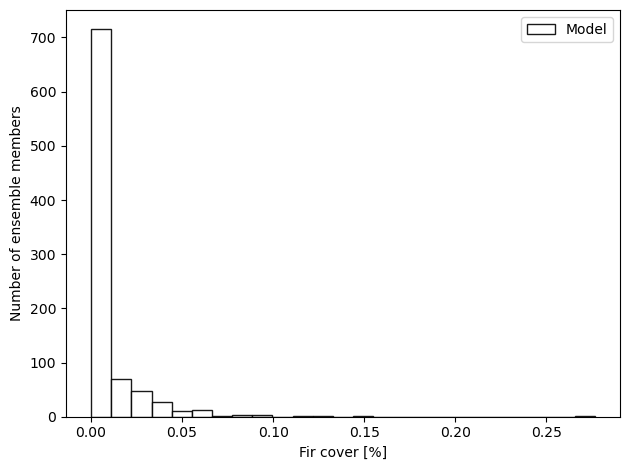

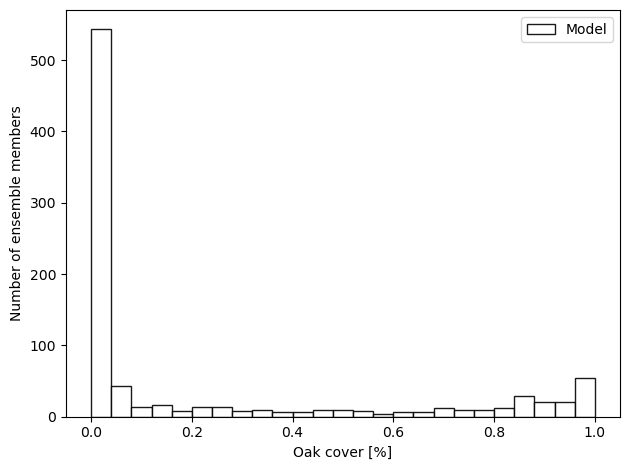

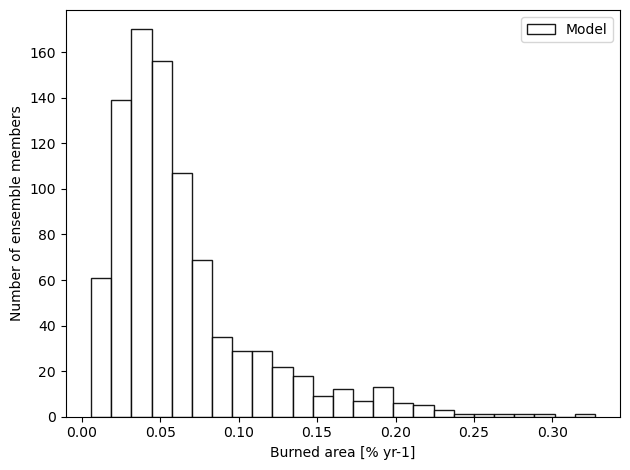

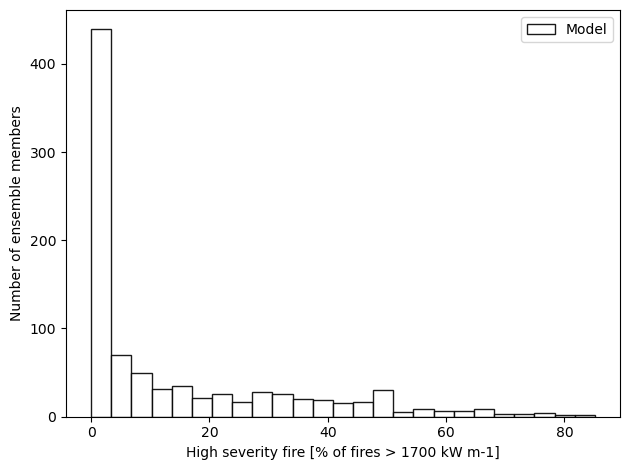

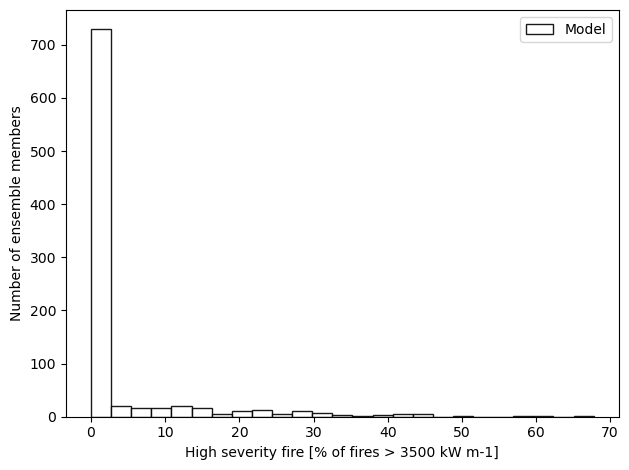

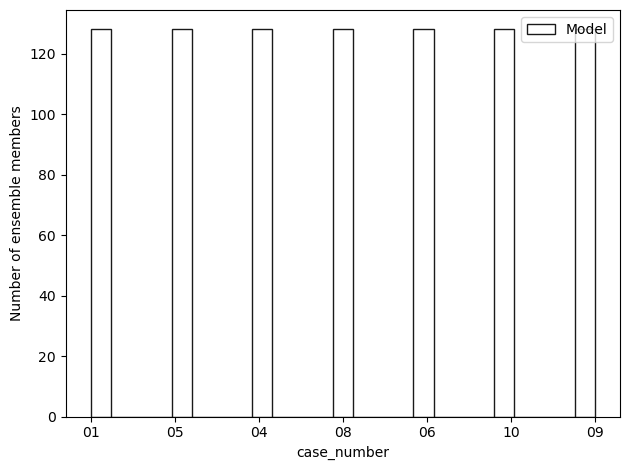

In [10]:
make_histograms_of_metrics(df)